## Description

**Author: Łukasz Łaszczuk**

This notebook focuses on training decision trees and tuning it for detecting fraudulent credit card transactions.

## Import modules and data

In [1]:
import copy
import warnings
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
from sklearn.model_selection import (learning_curve, RandomizedSearchCV,
                                     StratifiedShuffleSplit, StratifiedKFold,
                                     train_test_split,
                                    )
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix,
                             f1_score, precision_recall_curve,
                             precision_score, recall_score, 
                             roc_auc_score, roc_curve,
                            )
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import  MinMaxScaler
from sklearn.utils.class_weight import (compute_class_weight,
                                        compute_sample_weight)
from sklearn.base import clone
from scikitplot.metrics import plot_precision_recall
from joblib import dump, load
from io import StringIO
from ipywidgets import Image


In [5]:
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

**Firstly, let's perform feature engineering**

In [6]:
def feature_engineering(df):
    
    """Perform feature engineering:
    a) create binary feature for 99.99 frauds taken in groups;
    b) take log(1+a) of Amount;
    c) perform sine and cosine transformation of "seconds after midnight";
    d) transform "seconds after midnight" to [0,1].
    """
    
    # Amount equal 99.99, transaction concluded in group 
    df_new = df.sort_values(["Time", "V1"])
    df_new = df_new[(df_new["Amount"] == 99.99)]
    df_new["diff"] = df_new["Time"].diff()
    diff = df_new["diff"]
    df = df.join(diff)
    df["Amount_99_group"] = (df["diff"] < 40).astype(int)
    df.drop("diff", axis=1, inplace=True)
    
    # Log transform of Amount
    df["Amount"] = np.log1p(df["Amount"])
    
    # Sine and cosine transformation of time
    seconds_in_day = 86400
    df["Time"] = df["Time"] % seconds_in_day  # "seconds after midnight"
    df["Sin_time"] = np.sin(2*np.pi*df["Time"] / seconds_in_day)
    df["Cos_time"] = np.cos(2*np.pi*df["Time"] / seconds_in_day)
    
    # Transform "seconds after midnight"
    min_max_scaler = MinMaxScaler()
    df["Time"] = min_max_scaler.fit_transform(np.array(df.loc[:, "Time"]).reshape(-1,1))

    return df

In [7]:
df = pd.read_csv("data\data1.csv")
df.drop(df.columns[0], inplace=True, axis=1)  # Drop first column (index)
df = feature_engineering(df)

In [233]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,Amount_99_group,Sin_time,Cos_time
0,0.477025,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,...,0.504076,0.176423,0.541252,-0.121212,-0.064948,4.189503,0,0,0.143924,-0.989589
1,0.613313,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,...,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,0.693147,0,0,-0.653255,-0.757138
2,0.792634,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627285,2.452801,0.319063,...,0.091483,-0.038373,-0.410096,0.088944,0.026973,3.456317,0,0,-0.964365,0.264574
3,0.431457,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,...,0.146116,0.342753,0.198887,-0.117734,-0.061706,5.044006,0,0,0.417537,-0.908660
4,0.403042,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,...,0.049313,0.157236,0.606729,-0.063450,-0.071105,2.397895,0,0,0.572265,-0.820069


**We will use stratified train test split to ensure the proportion of frauds in train and test set is the same**

In [17]:
X = df.loc[:, df.columns != "Class"]  # select features for predicting Class
X = X.astype("float32")  # convert the chosen features to float32 type
y = df["Class"]  # target column
y = y.astype("int32")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    stratify=y,
                                                    random_state = 2019)
# Stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)

## Optimizing hyperparameters of decision tree with RandomizedSearchCV

**To compensate class imbalance, we use class_weight argument. We define positive class weight as: $$ positives\_weight = \frac{\# transactions}{\# frauds}$$**

In [9]:
class_weights = compute_class_weight("balanced", np.unique(y_train),
                                     y_train)

In [10]:
weights = compute_sample_weight(class_weight={0: class_weights[0],
                                              1: class_weights[1]},
                                y=y_train, indices=None)

In [237]:
# Weights computed by function: negative class, positive class
np.unique(weights)

array([  0.50086423, 289.77325581])

In [278]:
df_frauds = df[df["Class"] == 1]
scale_pos_weight = df.shape[0] / df_frauds.shape[0]
tree = DecisionTreeClassifier(random_state=2019)

params = {"max_depth": np.arange(4,16),
          "min_samples_leaf": np.arange(7,20),
          "min_samples_split": np.arange(2,16),
         }

In [331]:
# For scoring and evaluating, we use average_precision
grid = RandomizedSearchCV(tree, params,
                          n_iter=100, scoring="average_precision",
                          cv=skf, verbose=1,
                          n_jobs=-1, random_state=2019,)

In [332]:
# Weights argument defines weight of each sample
grid.fit(X_train, y_train, weights)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.0min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2019, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0....
                                                    splitter='best'),
                   iid='warn', n_iter=100, n_jobs=-1,
   

In [333]:
# Let's take a look at best models
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score")
results = results.reset_index(drop=True)
results.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.744744,0.093709,0.013966,0.001919,13,17,8,"{'min_samples_split': 13, 'min_samples_leaf': ...",0.784123,0.712198,0.831567,0.710092,0.778792,0.763355,0.046425,1
1,8.540688,0.554439,0.012965,0.000892,9,17,8,"{'min_samples_split': 9, 'min_samples_leaf': 1...",0.784123,0.712198,0.831567,0.710092,0.778792,0.763355,0.046425,1
2,7.837207,0.116271,0.012367,0.000488,15,17,8,"{'min_samples_split': 15, 'min_samples_leaf': ...",0.784123,0.712198,0.831567,0.710092,0.778792,0.763355,0.046425,1
3,6.861365,0.071169,0.013165,0.001164,11,17,7,"{'min_samples_split': 11, 'min_samples_leaf': ...",0.787135,0.704395,0.821016,0.707157,0.791785,0.762298,0.047597,4
4,6.900664,0.416175,0.012766,0.001323,2,19,8,"{'min_samples_split': 2, 'min_samples_leaf': 1...",0.808161,0.692673,0.830468,0.703159,0.774388,0.761770,0.055210,5
5,7.848168,0.079676,0.014163,0.001595,12,19,8,"{'min_samples_split': 12, 'min_samples_leaf': ...",0.808161,0.692673,0.830468,0.703159,0.774388,0.761770,0.055210,5
6,5.544737,0.069339,0.013763,0.006129,10,19,7,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.810751,0.685693,0.819672,0.700663,0.791785,0.761713,0.056876,7
7,6.991052,0.116469,0.013364,0.000798,14,19,7,"{'min_samples_split': 14, 'min_samples_leaf': ...",0.810751,0.685693,0.819672,0.700663,0.791785,0.761713,0.056876,7
8,8.679683,0.116926,0.016755,0.004653,5,16,9,"{'min_samples_split': 5, 'min_samples_leaf': 1...",0.783071,0.703711,0.821776,0.720116,0.778807,0.761496,0.043475,9
9,7.711633,0.063727,0.014663,0.002307,2,18,8,"{'min_samples_split': 2, 'min_samples_leaf': 1...",0.780458,0.711450,0.831567,0.704410,0.778792,0.761336,0.047607,10


In [472]:
# Cross validation average_precision of the model
grid.best_score_

0.7633546385165061

In [473]:
# Best parameters
grid.best_params_

{'min_samples_split': 13, 'min_samples_leaf': 17, 'max_depth': 8}

In [474]:
model = grid.best_estimator_

In [598]:
# Average_precision of best estimator from param grid on test set
y_pred = model.predict(X_test)
average_precision_score(y_test,y_pred)

0.705699020432487

**This score is ca. 0.17 larger than the baseline score with decision tree**

In [597]:
f1_score(y_test,y_pred)

0.8341708542713568

In [552]:
confusion_matrix(y_test,y_pred)

array([[63966,     5],
       [   28,    83]], dtype=int64)

In [557]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [558]:
tn, fp, fn, tp

(63966, 5, 28, 83)

**The number of false negatives is bigger than false positives, meaning that we didn't detect 28 frauds. Let's see how much money was lost because of that fact.**

**We can define a custom loss function which takes into account the money lost due to fraudulent transactions that were not detected (false negatives) and the money that has to be spent to check if the transaction was fraudulent. Then we can define a loss function as:
$$ loss = C_{FN}+\# FP\cdot cost+\# TP\cdot cost,$$ where $C_{FN}$ is the total amount of false negative transactions, $\# FP, \#TP$ is the number of false positives and true positives and cost is the amount of money we have to spend to check whether transaction was fraudulent or not.**

**We set the cost to 0.5.**

In [582]:
threshold = 0.5
check_cost = 0.5
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
overall_cost = (np.sum(X_test[(y_test == 1) & (y_pred == 0)]["Amount"]) \
+ fp * check_cost \
+ tp * check_cost)

print("Cost with {} threshold: {}".format(threshold, overall_cost))

Cost with 0.5 threshold: 133.31930541992188


In [599]:
average_precision_score(y_test,y_pred)

0.705699020432487

In [583]:
y_proba = model.predict_proba(X_test)

In [592]:
# Set threshold
threshold = 0.17
y_test_threshold = (y_proba[:, 1] >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_threshold).ravel()
print(confusion_matrix(y_test, y_test_threshold))

[[63949    22]
 [   23    88]]


In [594]:
overall_cost = np.sum(X_test[(y_test == 1) & (y_test_threshold == 0)]["Amount"]) \
+ fp * check_cost \
+ tp * check_cost

print("Cost with {} treshold: {}".format(threshold,
                                                   overall_cost))

Cost with 0.17 treshold: 128.5752944946289


In [595]:
average_precision_score(y_test, y_test_threshold)

0.6345931493742112

**By setting threshold to 0.17 we reduced the number of FN by 5. The cost was an increse in FP by 17. Even though the average_precision_score decreased, we can see that the overall cost is also lower, which means we lost less money.**

**Conclusion: Depending on the objective, we might want to set different thresholds.**

**Let's see the shape of precision-recall curve of the model we've built**

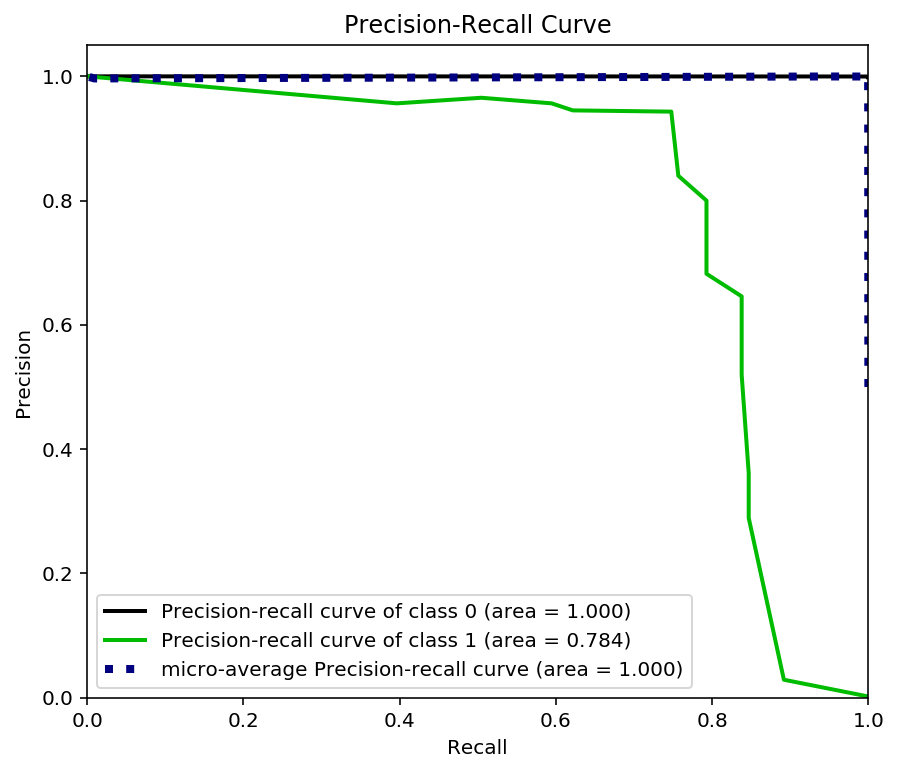

In [600]:
plot_precision_recall(y_test, y_proba, figsize=(7,6));

**Note: There is a difference between average_precision_score for optimal threshold and area calculated by plot_precision_recall. In sklearn documentation, we can read that AUPRC calculated by the second function uses linear interpolation and can be a little bit too optimistic, so we stick to average_precision_score.**

In [602]:
# Best tree visualization
dot_data = StringIO()
export_graphviz(decision_tree=model,
               out_file=dot_data, filled=True,
               feature_names=df.drop(['Class'],axis=1).columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x07\x97\x00\x00\x04\xa7\x08\x06\x00\x00\x00\xc1\x91\…

In [606]:
def plot_importances(est):
    
    columns = df.drop(["Class"], axis=1).columns
    importances = est.feature_importances_
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(columns, importances)
    ax.set_title("{} feature importances".format(type(est).__name__))
    
    return fig

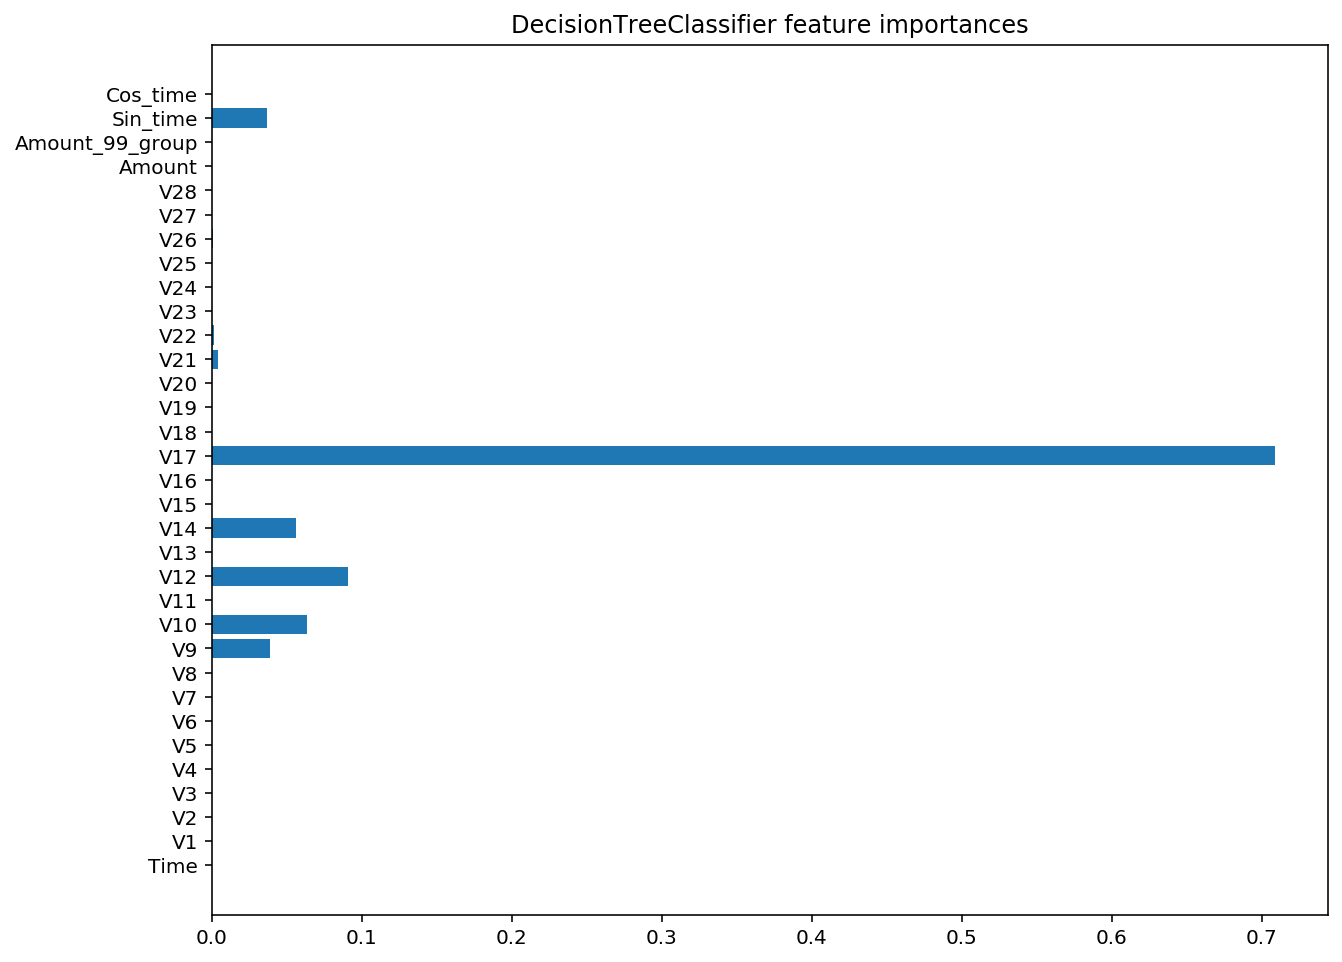

In [607]:
fig = plot_importances(model)

**Note: By plotting feature importances we can see that most of the features were not considered.**

In [620]:
# Save best model
dump(model, "best_tree.joblib")

['best_tree.joblib']